In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os

# --- 1. CONFIGURATION & STYLE ---
COLOR_PALETTE = [
    "#0072B2", "#E69F00", "#009E73", "#D55E00", "#CC79A7", "#F0E442", "#8B4513",
    "#56B4E9", "#F0A3FF", "#FFB400", "#00BFFF", "#90EE90", "#FF6347", "#8A2BE2",
    "#CD5C5C", "#4682B4", "#FFDEAD", "#32CD32", "#D3D3D3", "#999999"
]
METRIC = "power_draw"

In [2]:
def load_and_process_data():
    """Loads parquet files and aligns timestamps."""
    print("Loading data...")

    # Check if data exists (Warning only)
    if not os.path.exists("../data/footprinter.parquet"):
        print("Warning: ../data/footprinter.parquet not found.")

    # Load Data
    fp = pd.read_parquet("../data/footprinter.parquet").groupby("timestamp")[METRIC].sum()
    odt = pd.read_parquet("../data/opendt.parquet").groupby("timestamp")[METRIC].sum()
    rw = pd.read_parquet("../data/real_world.parquet").groupby("timestamp")[METRIC].sum()

    # --- Processing ---
    print("Processing and aligning data...")

    def average_every_n(series, n):
        return series.groupby(np.arange(len(series)) // n).mean()

    # Average to 5-min intervals
    # OpenDT (2.5m) -> 2 samples = 5 min
    # Others (30s) -> 10 samples = 5 min
    odt = average_every_n(odt, 2)
    fp = average_every_n(fp, 10)
    rw = average_every_n(rw, 10)

    # Sync lengths (trim to shortest)
    min_len = min(len(odt), len(fp), len(rw))
    odt = odt.iloc[:min_len]
    fp = fp.iloc[:min_len]
    rw = rw.iloc[:min_len]

    # Force Start Time to 2022-10-06 22:00:00
    start_time = pd.Timestamp("2022-10-06 22:00:00")
    timestamps = pd.date_range(start=start_time, periods=min_len, freq="5T")

    # Apply clean timestamps
    odt.index = timestamps
    fp.index = timestamps
    rw.index = timestamps

    return fp, odt, rw, timestamps, min_len

def calculate_mape(ground_truth, simulation):
    """Calculates Mean Absolute Percentage Error (MAPE)."""
    R = ground_truth.values
    S = simulation.values
    return np.mean(np.abs((R - S) / R)) * 100

In [3]:
def generate_experiment_pdf(x, fp, odt, rw, timestamps, min_len):
    """Generates the final publication plot."""
    print("Generating final experiment PDF...")

    # Setup Figure (12, 5 size)
    plt.figure(figsize=(12, 5))
    plt.grid(True)

    # Plot Lines (Thick lines: lw=3)
    plt.plot(x, rw.values / 1000, label="Ground Truth", color=COLOR_PALETTE[0], lw=3)
    plt.plot(x, fp.values / 1000, label="FootPrinter", color=COLOR_PALETTE[1], lw=3)
    plt.plot(x, odt.values / 1000, label="OpenDT", color=COLOR_PALETTE[2], lw=3)

    ax = plt.gca()

    # --- Formatting X-Axis (Fixed Dates) ---
    target_dates = ["2022-10-08", "2022-10-10", "2022-10-12", "2022-10-14"]
    tick_dates = pd.to_datetime(target_dates)

    tick_positions = []
    tick_labels = []

    for d in tick_dates:
        seconds_diff = (d - timestamps[0]).total_seconds()
        # 300 seconds = 5 minutes
        idx = int(seconds_diff / 300)

        tick_positions.append(idx)
        tick_labels.append(d.strftime("%d/%m"))

    ax.set_xticks(tick_positions)
    # INCREASED FONT SIZE (was 14)
    ax.set_xticklabels(tick_labels, fontsize=20)

    # Extend limit slightly to show last tick
    max_tick = max(tick_positions)
    if ax.get_xlim()[1] < max_tick:
        ax.set_xlim(right=max_tick + (min_len * 0.02))

    # --- Formatting Y-Axis ---
    y_formatter = FuncFormatter(lambda val, _: f"{int(val):,}")
    ax.yaxis.set_major_formatter(y_formatter)
    # INCREASED FONT SIZE (was 14)
    ax.tick_params(axis='y', labelsize=20)

    # Labels (INCREASED FONT SIZE)
    plt.ylabel("Power Draw [kW]", fontsize=22, labelpad=10)
    plt.xlabel("Time [day/month]", fontsize=22, labelpad=10)
    plt.ylim(bottom=0)

    # Legend (INCREASED FONT SIZE)
    # Moved slightly higher (1.20) to make room for the larger text
    plt.legend(fontsize=18, loc="upper center", bbox_to_anchor=(0.5, 1.22), ncol=3, framealpha=1)

    plt.tight_layout()

    # Save
    plt.savefig("exp1_plot_power_draw.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    plt.close()

Loading data...
Processing and aligning data...
Stats Calculated (Not plotted) - FP: 7.86%, ODT: 5.33%
Generating final experiment PDF...


/var/folders/zp/wbw59jc53p912jytp6zlm1wr0000gs/T/ipykernel_19539/30282531.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range(start=start_time, periods=min_len, freq="5T")


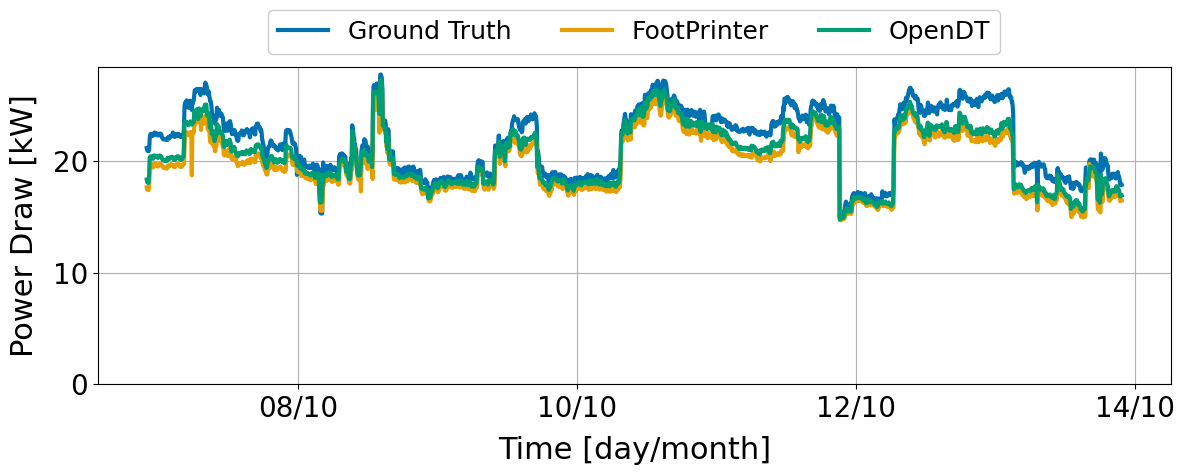

Done! File generated: 'experiment1.pdf'


In [4]:
# 1. Load Data
fp, odt, rw, timestamps, min_len = load_and_process_data()
x = np.arange(min_len)

# 2. Calculate Stats
mape_fp = calculate_mape(rw, fp)
mape_odt = calculate_mape(rw, odt)
print(f"Stats Calculated (Not plotted) - FP: {mape_fp:.2f}%, ODT: {mape_odt:.2f}%")

# 3. Generate Plot
generate_experiment_pdf(x, fp, odt, rw, timestamps, min_len)
print("Done! File generated: 'experiment1.pdf'")